In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch

import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import math

In [2]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
import nvidia_smi
nvidia_smi.nvmlInit()

handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

nvidia_smi.nvmlShutdown()

Total memory: 50962169856
Free memory: 32180207616
Used memory: 18781962240


In [11]:
print("Get memory info", torch.cuda.mem_get_info(device=None)) 
print("Get number of devices available: ", torch.cuda.device_count())

print("Memory stats about which device is free: ")

nvidia_smi.nvmlInit()

deviceCount = nvidia_smi.nvmlDeviceGetCount()
for i in range(deviceCount):
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    print("Device {}: {}, Memory : ({:.2f}% free): {}(total), {} (free), {} (used)".format(i, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total, info.total, info.free, info.used))

nvidia_smi.nvmlShutdown()

print("Current Device:  ", torch.cuda.current_device()) 


Get memory info (33931329536, 50962169856)
Get number of devices available:  3
Memory stats about which device is free: 
Device 0: b'Quadro RTX 8000', Memory : (60.83% free): 50962169856(total), 31002656768 (free), 19959513088 (used)
Device 1: b'Quadro RTX 8000', Memory : (68.84% free): 50962169856(total), 35081617408 (free), 15880552448 (used)
Device 2: b'Quadro RTX 8000', Memory : (66.58% free): 50962169856(total), 33931329536 (free), 17030840320 (used)
Current Device:   2


In [10]:
torch.cuda.set_device(2)
torch.cuda.empty_cache() 

In [7]:
train = pd.read_csv('../data/edu_train.csv')
unique_labels = train.updated_label.unique().tolist()
unique_labels.remove('appeal to emotion')
print(unique_labels)

['false causality', 'ad populum', 'circular reasoning', 'fallacy of relevance', 'faulty generalization', 'ad hominem', 'fallacy of extension', 'equivocation', 'fallacy of logic', 'fallacy of credibility', 'intentional', 'false dilemma', 'miscellaneous']


In [6]:

MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [7]:
class LogicalFallacy(Dataset):
    def __init__(self, dataset, tokenizer, max_len, attribute):
        self.tokenizer = tokenizer
        self.data = dataset
        self.text = dataset[attribute]
        self.targets = dataset.label
        self.max_len = max_len
        self.original_label = dataset.updated_label

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        

        return {
            'sentence': text,
            
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [8]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output
    



In [9]:
def predict(loader, label, epochs=1):
    model = torch.load('models_new/'+label+'trained_roberta.pt')
    model.eval()
    loss_function = torch.nn.CrossEntropyLoss()
    test_answers = [[[],[]], [[],[]]]
    for epoch in range(epochs):
        for steps, data in tqdm(enumerate(loader, 0)):
            sentence = data['sentence']
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
        
            outputs = model.forward(ids, mask, token_type_ids)
            _, max_indices = torch.max(outputs.data, dim=1)
            if epoch == epochs-1:
                for i in range(len(targets)):
                    test_answers[targets[i].item()][max_indices[i].item()].append([
                                                                        sentence[i], 
                                                                        targets[i].item(), 
                                                                        max_indices[i].item()
                                                                        ])
        return test_answers

                                                                

       


In [12]:
def driver_code(label):
   
    test_df = pd.read_csv('with GPT prompt text/'+label+'_test.csv')
    test_df = test_df[test_df['cleaner_prompt'].notna()]
    
    test_set = LogicalFallacy(test_df, tokenizer, MAX_LEN)

    
    

    test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
    
    test_loader = DataLoader(test_set, **test_params)

    
    value = predict(test_loader, label)
    return value



In [13]:
test_answers_list = []
for i in range(len(unique_labels)):
    
    test_answers = driver_code(unique_labels[i])
    test_answers_list.append(test_answers)

def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n
    

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [7]:
import pickle

# open a file, where you stored the pickled data
file = open('test_answers_1.pk', 'rb')

# dump information to that file
test_answers_list = pickle.load(file)

# close the file
file.close()
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n


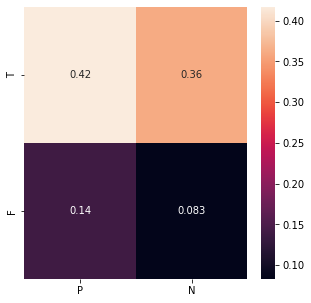

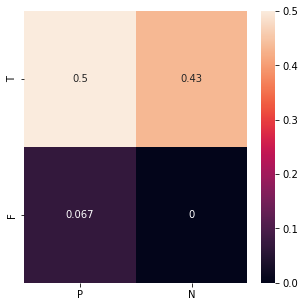

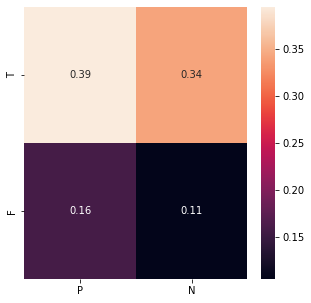

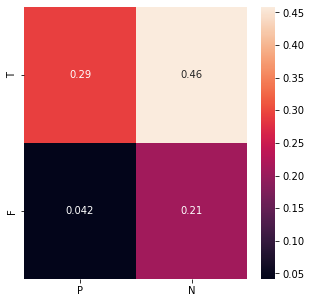

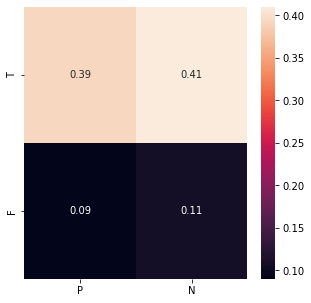

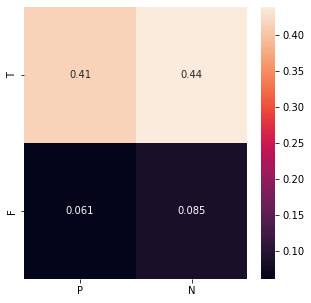

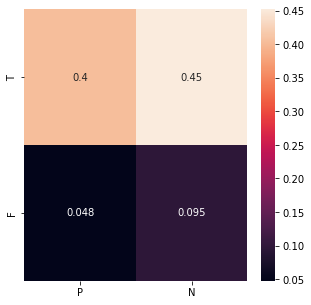

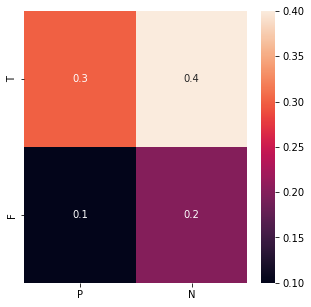

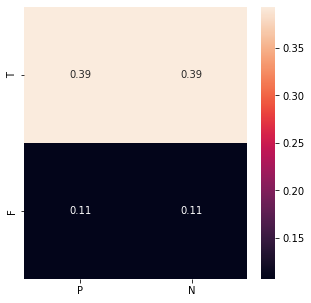

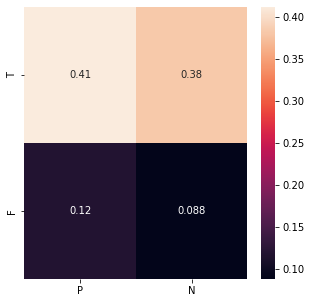

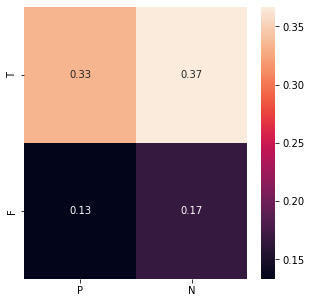

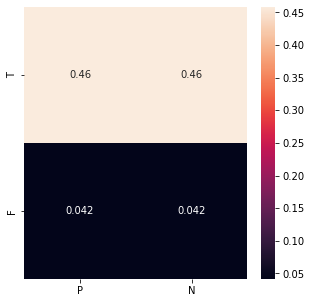

In [31]:
train = pd.read_csv('data/edu_train.csv')
unique_labels = train.updated_label.unique().tolist()
unique_labels.remove('appeal to emotion')

tp_list, tn_list, fp_list, fn_list = [], [], [], [] 
accuracy_list, precision_list, recall_list = [], [], [] 
for i in range(len(unique_labels)-1):
    test_df = pd.read_csv('data/'+unique_labels[i]+'_test.csv')
    len_num = len(test_df)

    tp=len(test_answers_list[i][1][1])/len_num
    fn=len(test_answers_list[i][1][0])/len_num
    fp=len(test_answers_list[i][0][1])/len_num
    tn=len(test_answers_list[i][0][0])/len_num


    array_matrix = [[tp,tn], 
                    [fp,fn]]
    df_cm = pd.DataFrame(array_matrix, index = ['T', 'F'],
                    columns = ['P', 'N'])
    plt.figure(figsize = (5,5))
    sn.heatmap(df_cm, annot=True)

    precision = truncate( tp / (tp + fp), 3) 
    recall = truncate( tp/ (tp + fn), 3)
    accuracy =truncate( tp+tn/(tp+tn+fp+fn), 3) 

    tp_list.append(truncate(tp,3)) 
    tn_list.append(truncate(tn, 3)) 
    fp_list.append(truncate(fp,3)) 
    fn_list.append(truncate(fn, 3))
    accuracy_list.append(accuracy) 
    recall_list.append(recall) 
    precision_list.append(precision) 
    

In [32]:
extract_classes = [] 

token_labels_dictionary = { 
        'lbl01':'false causality', 
        'lbl02':'ad populum', 
        'lbl03':'circular reasoning',
        'lbl04':'fallacy of relevance', 
        'lbl05': 'faulty generalization', 
        'lbl06':'ad hominem', 
        'lbl07':'fallacy of extension', 
        'lbl08':'equivocation', 
        'lbl09':'fallacy of logic', 
        'lbl10':'fallacy of credibility',
        'lbl11': 'intentional', 
        'lbl12':'false dilemma', 
        'lbl13':'miscellaneous', 
        'lbl14': 'appeal to emotion'}

test_df = pd.read_csv('data/'+unique_labels[0]+'_test.csv')
for test_answers in test_answers_list:
    classes = [] 
    for false_positive in test_answers[0][1]:
        if false_positive[0][-5:] in token_labels_dictionary:
            token = token_labels_dictionary[false_positive[0][-5:]]
        else:
            print(false_positive[0][-5:] )
        classes.append(token)
    classes = list(set(classes))
    extract_classes.append(classes)
 


In [33]:
dictionary = {
    'fallacy class': unique_labels[:-1], 
    'accuracy': accuracy_list,
    'precision': precision_list, 
    'recall': recall_list, 
    'TP': tp_list, 
    'TN': tn_list,
    'FP':fp_list, 
    'FN':fn_list, 
    'Classes for False Positive:': extract_classes
}
df = pd.DataFrame.from_dict(dictionary) 
df.to_csv (r'results/results_classifier_bin_prev.csv', index = False, header=True) 



In [30]:
print( len(unique_labels[:-1]) , len(accuracy_list), len(precision_list), len( recall_list), len(tp_list), len(tn_list), len(fp_list), len(fn_list), len(extract_classes))

12 12 12 12 0 12 12 12 12


In [86]:
total = 0 
samples = []
for i in range(len(unique_labels)-1): 
    train_df = pd.read_csv('data/'+unique_labels[i]+'_train.csv')
    samples.append(len(train_df))
    total += len(train_df) 


In [109]:
samples_new  = [ truncate(elt/total, 3)*100 for elt in samples]

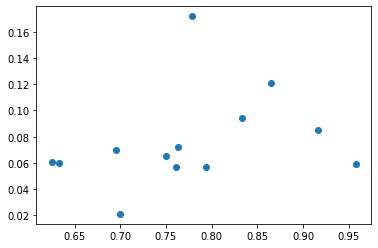

In [98]:
import matplotlib.pyplot
import pylab

x = accuracy_list
y = samples_new
matplotlib.pyplot.scatter(x,y)

matplotlib.pyplot.show()

In [99]:
acc_list = [0.7866,
0.863,
0.75,
0.8233,
0.9433,
0.8733,
0.8833,
0.966,
0.9433,
0.776,
0.9033,
0.8866,
0.8833,]

In [110]:
distribution = [ 17.22,
9.395,
7.23,
8.53,
12.14,
6.533,
7.019,
5.39,
2.105,
5.72,
6.15,
5.777,
6.047]

In [101]:
distribution = [elt/100 for elt in distribution]

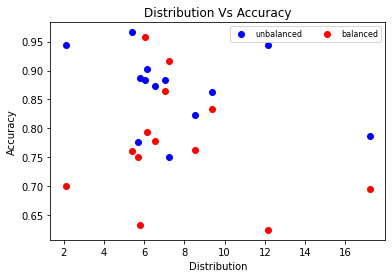

In [123]:
import matplotlib.pyplot as plt
import pylab

x = acc_list+accuracy_list
y = distribution+samples_new
plt.title("Distribution Vs Accuracy")

plt.xlabel("Distribution")
plt.ylabel("Accuracy")
a = plt.scatter(distribution, acc_list, color='blue')
b = plt.scatter(distribution,accuracy_list, color='red')
plt.legend((a, b),
           ('unbalanced', 'balanced'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=8)



plt.show()


In [115]:
prec_list = [0,
0.041,
0.0625,
0.0294,
0.8292,
0,
0.05,
0.55,
0,
0.0217,
0,
0,
0]

In [119]:
rec_list = [0,
0.0526,
0.0163,
0.0476,
0.7727,
0,
0.0588,
0.916,
0,
0.0434,
0,
0,
0]